### 라이브러리 불러오기

In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__) # 2.4.1

import numpy as np
import os

2.4.1


### config
네트워크, 인풋 이미지, 학습 등을 위해 필요한 기본 정보들을 선언한다.

In [ ]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUM_CLASSES = 10
CHANNELS = 3

### 데이터 준비
CIFAR-10 데이터셋을 로드하고, preprocessing 과정이다. CIFAR-10 데이터셋은 은 50,000개의 학습 데이터와 10,000개의 테스트 데이터로 구성된 32*32 크기의 이미지 데이터셋이다. 총 10개 class로 분류되어있다. 

기본적으로 모든 이미지에 resize와 per-pixel mean subtraction이 들어간다. 훈련 데이터셋에 대해서는 data augmentation을 추가로 진행한다. augmentaion은 4px padding 이후 32*32 size random crop과 horizontal flip이 들어간다.

In [ ]:
from keras.datasets import cifar10

def generate_datasets():
  (X_train, y_train), (X_test, y_test) = cifar10.load_data() # cifar 10 데이터셋 로드
  X_test, y_test = resize_and_rescale(X_test, y_test)
  X_train, y_train = augment(X_train, y_train)
  return X_train, y_train, X_test, y_test

def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
  if os.path.exists('pixel_mean_value.npy'):
    mean_image = np.load('pixel_mean_value.npy')
  else:
    mean_image = np.mean(image, axis=0)
  image -= mean_image
  image = (image / 128.0)
  return image, label

def augment(image,label):
  image, label = resize_and_rescale(image, label)
  # Add 4 pixels of padding
  image = tf.map_fn(lambda img: tf.image.resize_with_crop_or_pad(img, IMAGE_WIDTH + 4, IMAGE_HEIGHT + 4), image)
   # Random crop back to the original size
  image = tf.map_fn(lambda img: tf.image.random_crop(img, size=[IMAGE_WIDTH, IMAGE_HEIGHT, 3]), image)
  image = tf.map_fn(lambda img: tf.image.random_flip_left_right(img), image)  
  return image, label

### 모델 생성
여기서는 20레이어로 구성된 Resnet을 사용한다. Resnet에는 Basic block으로 여러 convolution layer를 묶고, 여기에 initial mapping을 더하는 방식을 사용한다. Basic block은 2쌍 이상의 convolution과 batch normalization layer로 구성되어 있다. 아래 표를 참고하면 우리는 n=3을 넣어서 마지막 fully connected layer까지 포함하여 20개의 레이어를 쌓을 것이다. 

![](https://github.com/SUNGBEOMCHOI/SungBeomChoi.github.io/blob/master/assets/img/posts/2021-03-17-Resnet_Implementation/fig3.JPG?raw=true)

#### 논문의 Implementaion

-   Weight decay: 0.0001, momentum: 0.9
-   모든 convonlution filter의 size는 3*3
-   He weight initialization
-   Batch normalization
-   batch size : 128
-   learning rate는 0.1로 시작하고, 32k와 48k iteration에 각각 10으로 나눠준다.
-   마지막 부분에 global average pooling을 적용

<br>

#### 나의 Implementaion

-   learning rate를 2epoch 이상 validation loss가 떨어지지 않으면 0.1을 곱한다. 최종 0.001 까지 떨어뜨린다.
-   Early stopping을 사용하여 validation loss가 4epoch 이상 떨어지지않으면 학습을 멈춘다.

In [ ]:
class BasicBlock(tf.keras.layers.Layer):  
  def __init__(self, filter_num, stride=1):
    super(BasicBlock, self).__init__()
    initializer = tf.keras.initializers.HeNormal()
    l2 = tf.keras.regularizers.l2(0.0001)
    self.conv1 = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(3,3), strides=stride, padding='same', kernel_regularizer=l2, kernel_initializer=initializer)
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.conv2 = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(3,3), strides=1, padding='same', kernel_regularizer=l2, kernel_initializer=initializer)
    self.bn2 = tf.keras.layers.BatchNormalization()
    if stride != 1:
      self.downsample = tf.keras.Sequential()
      self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(1,1), strides=stride, kernel_regularizer=l2, kernel_initializer=initializer))
      self.downsample.add(tf.keras.layers.BatchNormalization())
    else:
      self.downsample = lambda x: x

  def call(self, inputs, **kwargs):
    residual = self.downsample(inputs)

    x = self.conv1(inputs)
    x = self.bn1(x)
    x = tf.nn.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)

    output = tf.nn.relu(tf.keras.layers.add([residual, x]))

    return output


def make_basic_block_layer(filter_num, blocks, stride=1):
  res_block = tf.keras.Sequential()
  res_block.add(BasicBlock(filter_num, stride=stride))

  for _ in range(1, blocks):
    res_block.add(BasicBlock(filter_num, stride=1))

  return res_block


class ResNet(tf.keras.Model):  
  def __init__(self, layer_params):
    super(ResNet, self).__init__()
    initializer = tf.keras.initializers.HeNormal()
    l2 = tf.keras.regularizers.l2(0.0001)
    self.conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=1, padding='same', kernel_regularizer=l2, kernel_initializer=initializer)
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.layer1 = make_basic_block_layer(filter_num=16, blocks=layer_params[0], stride=2)
    self.layer2 = make_basic_block_layer(filter_num=32, blocks=layer_params[1], stride=2)
    self.layer3 = make_basic_block_layer(filter_num=64, blocks=layer_params[2], stride=2)
    self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
    self.fc = tf.keras.layers.Dense(units=NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_regularizer=l2, kernel_initializer=initializer)

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = tf.nn.relu(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.avgpool(x)
    output = self.fc(x)

    return output

def get_model():
  model = ResNet(layer_params=[3, 3, 3])
  model.build(input_shape=(None, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS))
  model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=False), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

### 학습

In [ ]:
X_train, y_train, X_test, y_test = generate_datasets()

In [ ]:
print('train input shape: ', X_train.shape)
print('test input shape: ', X_test.shape)
print('train output shape: ', y_train.shape)
print('train oupput shape: ', y_train.shape)

train input shape:  (50000, 32, 32, 3)
test input shape:  (10000, 32, 32, 3)
train output shape:  (50000, 1)
train oupput shape:  (50000, 1)


In [ ]:
model = get_model()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  448       
_________________________________________________________________
batch_normalization (BatchNo multiple                  64        
_________________________________________________________________
sequential (Sequential)      (None, 16, 16, 16)        14640     
_________________________________________________________________
sequential_2 (Sequential)    (None, 8, 8, 32)          52320     
_________________________________________________________________
sequential_4 (Sequential)    (None, 4, 4, 64)          207040    
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  650 

In [ ]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')

history = model.fit(X_train, y_train, epochs=180, validation_split=0.1, batch_size=BATCH_SIZE, callbacks=[lr_schedule, early_stopping])

Epoch 1/180
352/352 [==============================] - 41s 18ms/step - loss: 2.0248 - accuracy: 0.3229 - val_loss: 1.9445 - val_accuracy: 0.3666
Epoch 2/180
352/352 [==============================] - 6s 16ms/step - loss: 1.4743 - accuracy: 0.5254 - val_loss: 1.5578 - val_accuracy: 0.5364
Epoch 3/180
352/352 [==============================] - 6s 16ms/step - loss: 1.2023 - accuracy: 0.6364 - val_loss: 1.3714 - val_accuracy: 0.5730
Epoch 4/180
352/352 [==============================] - 6s 16ms/step - loss: 1.0629 - accuracy: 0.6839 - val_loss: 1.1780 - val_accuracy: 0.6584
Epoch 5/180
352/352 [==============================] - 6s 16ms/step - loss: 0.9676 - accuracy: 0.7227 - val_loss: 1.1201 - val_accuracy: 0.6846
Epoch 6/180
352/352 [==============================] - 6s 16ms/step - loss: 0.8787 - accuracy: 0.7597 - val_loss: 1.0648 - val_accuracy: 0.7012
Epoch 7/180
352/352 [==============================] - 6s 16ms/step - loss: 0.8240 - accuracy: 0.7773 - val_loss: 1.3870 - val_accuracy

### 학습 그래프 그리기
10 epoch 정도 이후에는 학습이 거의 이루어지지 않고, 오버피팅된다. 최종  validation loss는 1.0정도, validation accuracy는 80% 정도 나온다. 해당 논문에서는 error rate가 8.75%인 것에 비해 잘 성능이 나오지 않았다.

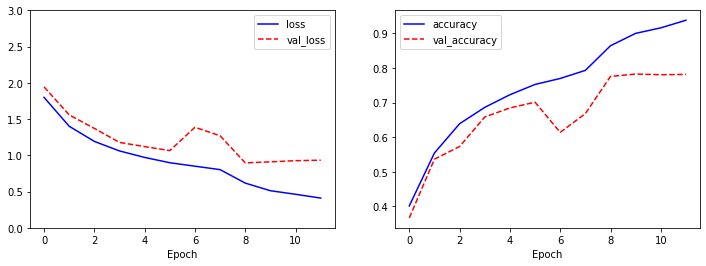

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.ylim(0, 3)
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

### 평가
Test 데이터의 정확도는 77% 정도이다. 

In [ ]:
model.evaluate(X_test, y_test, verbose=0) # [loss, accuracy]

[0.9589037895202637, 0.7718999981880188]

### 모델 다운로드

In [ ]:
# 모델 다운로드
model.save_weights('ResNet_20.h5') # 모델을 코랩에 저장

from google.colab import files
files.download('ResNet_20.h5')# 코랩에 저장된 모델을 로컬로 다운로드

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>